# rule based feature 추출

In [115]:
import numpy as np
import pandas as pd
from pathlib import Path
from extract_rule_based_features import ExtractFeatures, detect_bead
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
from collections import Counter

%matplotlib inline

## Anode

In [117]:
Anode_Normal = sorted([x for x in Path("../data/230507/Anode/Normal").glob("*.csv")])
Anode_Normal = sorted(Anode_Normal)
Anode_Normal

[PosixPath('../data/230507/Anode/Normal/1.csv'),
 PosixPath('../data/230507/Anode/Normal/10.csv'),
 PosixPath('../data/230507/Anode/Normal/11.csv'),
 PosixPath('../data/230507/Anode/Normal/12.csv'),
 PosixPath('../data/230507/Anode/Normal/14.csv'),
 PosixPath('../data/230507/Anode/Normal/15.csv'),
 PosixPath('../data/230507/Anode/Normal/16.csv'),
 PosixPath('../data/230507/Anode/Normal/17.csv'),
 PosixPath('../data/230507/Anode/Normal/18.csv'),
 PosixPath('../data/230507/Anode/Normal/19.csv'),
 PosixPath('../data/230507/Anode/Normal/2.csv'),
 PosixPath('../data/230507/Anode/Normal/20.csv'),
 PosixPath('../data/230507/Anode/Normal/20230412_110032_0__03_Total.csv'),
 PosixPath('../data/230507/Anode/Normal/21.csv'),
 PosixPath('../data/230507/Anode/Normal/22.csv'),
 PosixPath('../data/230507/Anode/Normal/23.csv'),
 PosixPath('../data/230507/Anode/Normal/24.csv'),
 PosixPath('../data/230507/Anode/Normal/25.csv'),
 PosixPath('../data/230507/Anode/Normal/26.csv'),
 PosixPath('../data/230507/

In [119]:
data = pd.read_csv("/root/Project_LG_Welding_AD/data/230507/Anode/Normal/20230412_110032_0__03_Total.csv")
len(data)

149999

In [120]:
data2 = pd.read_csv("/root/Project_LG_Welding_AD/data/230507/Anode/Normal/31.csv")
len(data2)

132499

In [3]:
Anode_Abnormal = sorted([x for x in Path("../data/230507/Anode/Abnormal").glob("*.csv")])
Anode_Abnormal

[PosixPath('../data/230507/Anode/Abnormal/20230412_105553_0__01_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_105804_0__02_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110249_0__04_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110451_0__05_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110735_0__06_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_110928_0__07_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111152_0__08_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111719_0__09_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_111935_0__10_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112153_0__11_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112415_0__12_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112642_0__13_Total.csv'),
 PosixPath('../data/230507/Anode/Abnormal/20230412_112855_0__14_Total.csv'),

In [4]:
len(Anode_Abnormal)

18

In [5]:
def check_graph(xs, att=None, piece=1, threshold=None):
    """
    anomaly score and anomaly label visualization

    Parameters
    ----------
    xs : np.ndarray
        anomaly scores
    att : np.ndarray
        anomaly labels
    piece : int
        number of figures to separate
    threshold : float(default=None)
        anomaly threshold

    Return
    ------
    fig : plt.figure
    """
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(12, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = np.arange(L, R)
        if piece == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.plot(xticks, xs[L:R], color='#0C090A')
        ymin, ymax = ax.get_ylim()
        ymin = 0
        ax.set_ylim(ymin, ymax)
        if len(xs[L:R]) > 0 and att is not None:
            ax.vlines(xticks[np.where(att[L:R] == 1)], ymin=ymin, ymax=ymax, color='#FED8B1',
                          alpha=0.6, label='true anomaly')
        ax.plot(xticks, xs[L:R], color='#0C090A', label='anomaly score')
        if threshold is not None:
            ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.8, label=f'threshold:{threshold:.4f}')
        ax.legend()

    return fig

In [6]:
def calc_point2point(predict, actual):
    """
    calculate f1 score by predict and actual.
    Args:
        predict (np.ndarray): the predict label
        actual (np.ndarray): np.ndarray
    """
    TP = np.sum(predict * actual)
    TN = np.sum((1 - predict) * (1 - actual))
    FP = np.sum(predict * (1 - actual))
    FN = np.sum((1 - predict) * actual)
    precision = TP / (TP + FP + 0.00001)
    recall = TP / (TP + FN + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    return f1, precision, recall, TP, TN, FP, FN


def adjust_predicts(score, label,
                    threshold=None,
                    pred=None,
                    calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    for i in range(len(score)):
        if actual[i] and predict[i] and not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                for j in range(i, 0, -1):
                    if not actual[j]:
                        break
                    else:
                        if not predict[j]:
                            predict[j] = True
                            latency += 1
        elif not actual[i]:
            anomaly_state = False
        if anomaly_state:
            predict[i] = True
    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def PA_percentile(score, label,
                  threshold=None,
                  pred=None,
                  K=100,
                  calc_latency=False):
    """
    Calculate adjusted predict labels using given `score`, `threshold` (or given `pred`) and `label`.
    Args:
        score (np.ndarray): The anomaly score
        label (np.ndarray): The ground-truth label
        threshold (float): The threshold of anomaly score.
            A point is labeled as "anomaly" if its score is lower than the threshold.
        pred (np.ndarray or None): if not None, adjust `pred` and ignore `score` and `threshold`,
        calc_latency (bool):
    Returns:
        np.ndarray: predict labels
    """
    if len(score) != len(label):
        raise ValueError("score and label must have the same length")
    score = np.asarray(score)
    label = np.asarray(label)
    latency = 0
    if pred is None:
        predict = score > threshold
    else:
        predict = pred
    actual = label > 0.1
    anomaly_state = False
    anomaly_count = 0
    anomalies = []

    for i in range(len(actual)):
        if actual[i]:
            if not anomaly_state:
                anomaly_state = True
                anomaly_count += 1
                anomalies.append([i, i])
            else:
                anomalies[-1][-1] = i
        else:
            anomaly_state = False

    for i, [start, end] in enumerate(anomalies):
        collect = Counter(predict[start:end + 1])[1]
        anomaly_count += collect
        collect_ratio = collect / (end - start + 1)

        if collect_ratio * 100 >= K and collect > 0:
            predict[start:end + 1] = True
            latency += (end - start + 1) - collect

    if calc_latency:
        return predict, latency / (anomaly_count + 1e-4)
    else:
        return predict


def calc_seq(score, label, threshold, K=0, calc_latency=False):
    """
    Calculate f1 score for a score sequence
    """
    if calc_latency:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        #predict, latency = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict, latency = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        t.append(latency)
        return t
    else:
        roc_auc = roc_auc_score(label, score)
        auprc = average_precision_score(label, score)
        # predict = adjust_predicts(score, label, threshold, calc_latency=calc_latency)
        predict = PA_percentile(score, label, threshold, K=K, calc_latency=calc_latency)
        t = list(calc_point2point(predict, label))
        t.append(roc_auc)
        t.append(auprc)
        return t


def bf_search(score, label, start, end=None, step_num=1, display_freq=1, K=0, verbose=True) -> object:
    """
    Find the best-f1 score by searching best `threshold` in [`start`, `end`).
    Returns:
        list: list for results
        float: the `threshold` for best-f1
    """
    if step_num is None or end is None:
        end = start
        step_num = 1
    search_step, search_range, search_lower_bound = step_num, end - start, start
    if verbose:
        print("search range: ", search_lower_bound, search_lower_bound + search_range)
    threshold = search_lower_bound
    m = (-1., -1., -1.)
    m_t = 0.0
    for i in range(search_step):
        threshold += search_range / float(search_step)
        target = calc_seq(score, label, threshold, K=K, calc_latency=True)
        if target[0] > m[0]:
            m_t = threshold
            m = target
        if verbose and i % display_freq == 0:
            print("cur thr: ", threshold, target, m, m_t)
    return m, m_t

### Dataset별 bead detection 후 time series concat

In [66]:
def slice_bead_data(path):
    "path: data 저장 경로 (str)"
    extractor = ExtractFeatures(path)
    data = extractor.data
    if 'Abnormal' in path:
        data['label'] = 1
        data['dataset_idx'] = path[-12:-10]
    else:
        data['label'] = 0
        data['dataset_idx'] = str(path).split('/')[-1].split('.')[0]
    bead_array = detect_bead(data['LO'])
    data['bead_num'] = '0'
    
    total_data = data.iloc[bead_array[0][0]:bead_array[0][1]+1]
    
    if 'Abnormal' in path:
        total_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(0)
    
    else:
        total_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(0)
    
    for i in range(1, len(bead_array)):
        bead_data = data.iloc[bead_array[i][0]:bead_array[i][1]]
        bead_data['bead_num'] = str(i)
        if 'Abnormal' in path:
            bead_data['identifier'] = 'Abnormal_'+ path[-12:-10] + '_' + str(i)
        
        else:
            bead_data['identifier'] = 'Normal_'+ str(path).split('/')[-1].split('.')[0] + '_' + str(i)
            
        total_data = pd.concat([total_data, bead_data])
                
    
    return total_data

## Train Test split
### Train -> 35개 정상 dataset 중 80%인 28개
### Test -> 18개 비정상 dataset + 정상 7개 dataset = 25개 dataset

In [113]:
len(Anode_Normal)

35

In [114]:
data_folder_list

[PosixPath('../data/230507/Anode/Normal/1.csv'),
 PosixPath('../data/230507/Anode/Normal/10.csv'),
 PosixPath('../data/230507/Anode/Normal/11.csv'),
 PosixPath('../data/230507/Anode/Normal/12.csv'),
 PosixPath('../data/230507/Anode/Normal/14.csv'),
 PosixPath('../data/230507/Anode/Normal/15.csv'),
 PosixPath('../data/230507/Anode/Normal/16.csv'),
 PosixPath('../data/230507/Anode/Normal/17.csv'),
 PosixPath('../data/230507/Anode/Normal/18.csv'),
 PosixPath('../data/230507/Anode/Normal/19.csv'),
 PosixPath('../data/230507/Anode/Normal/2.csv'),
 PosixPath('../data/230507/Anode/Normal/20.csv'),
 PosixPath('../data/230507/Anode/Normal/20230412_110032_0__03_Total.csv'),
 PosixPath('../data/230507/Anode/Normal/21.csv'),
 PosixPath('../data/230507/Anode/Normal/22.csv'),
 PosixPath('../data/230507/Anode/Normal/23.csv'),
 PosixPath('../data/230507/Anode/Normal/24.csv'),
 PosixPath('../data/230507/Anode/Normal/25.csv'),
 PosixPath('../data/230507/Anode/Normal/26.csv'),
 PosixPath('../data/230507/

In [67]:
data_folder_list = Anode_Normal + Anode_Abnormal
num_train_dataset = 28
Anode_Train = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
Anode_Test = pd.DataFrame(columns=['LO', 'BR', 'NIR', 'VIS', 'label','dataset_idx','bead_num'])
for i in range(num_train_dataset):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Anode_Train = pd.concat([Anode_Train, bead_i])

for i in range(num_train_dataset, len(data_folder_list)):
    bead_i = slice_bead_data(str(data_folder_list[i]))
    Anode_Test = pd.concat([Anode_Test, bead_i])


warning index: 40140
error index: 40239
warning index: 40690
error index: 40789
warning index: 41239
error index: 41338
warning index: 41788
error index: 41887
warning index: 42337
error index: 42436
warning index: 42886
error index: 42985
warning index: 43436
error index: 43535
warning index: 43986
error index: 44085
warning index: 44535
error index: 44634
warning index: 45085
error index: 45184
warning index: 45634
error index: 45733
warning index: 46184
error index: 46283
warning index: 46733
error index: 46832
warning index: 47282
error index: 47381
warning index: 47832
error index: 47931
warning index: 48381
error index: 48480
warning index: 48930
error index: 49029
warning index: 49479
error index: 49578
warning index: 50028
error index: 50127
warning index: 50577
error index: 50676
warning index: 51127
error index: 51226
warning index: 51676
error index: 51775
warning index: 52226
error index: 52325
warning index: 52775
error index: 52874
warning index: 53325
error index: 53424


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

warning index: 50276
error index: 50375
warning index: 50826
error index: 50925
warning index: 51375
error index: 51474
warning index: 51924
error index: 52023
warning index: 52473
error index: 52572
warning index: 53022
error index: 53121
warning index: 53572
error index: 53671
warning index: 54122
error index: 54221
warning index: 54671
error index: 54770
warning index: 55221
error index: 55320
warning index: 55770
error index: 55869
warning index: 56320
error index: 56419
warning index: 56869
error index: 56968
warning index: 57418
error index: 57517
warning index: 57968
error index: 58067
warning index: 58517
error index: 58616
warning index: 59066
error index: 59165
warning index: 59615
error index: 59714
warning index: 60164
error index: 60263
warning index: 60713
error index: 60812
warning index: 61263
error index: 61362
warning index: 61812
error index: 61911
warning index: 62362
error index: 62461
warning index: 62911
error index: 63010
warning index: 63461
error index: 63560


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


warning index: 52382
error index: 52480
error index: 52481
warning index: 52932
error index: 53031
warning index: 53481
error index: 53579
warning index: 54030
error index: 54128
warning index: 54579
error index: 54677
warning index: 55128
error index: 55226
warning index: 55678
error index: 55776
warning index: 56228
error index: 56326
warning index: 56777
error index: 56875
warning index: 57327
error index: 57425
warning index: 57876
error index: 57974
warning index: 58426
error index: 58524
warning index: 58975
error index: 59073
warning index: 59524
error index: 59622
warning index: 60074
error index: 60172
warning index: 60623
error index: 60721
warning index: 61172
error index: 61270
warning index: 61721
error index: 61819
error index: 61820
warning index: 62270
error index: 62368
error index: 62369
warning index: 62819
error index: 62917
warning index: 63369
error index: 63467
warning index: 63918
error index: 64016
warning index: 64468
error index: 64566
warning index: 65017
er

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


warning index: 41651
error index: 41750
warning index: 42151
error index: 42250
warning index: 42650
error index: 42749
warning index: 43149
error index: 43248
warning index: 43648
error index: 43747
warning index: 44146
warning index: 44147
error index: 44245
warning index: 44647
error index: 44745
warning index: 45146
warning index: 45147
error index: 45245
warning index: 45646
error index: 45744
warning index: 46146
error index: 46244
warning index: 46645
error index: 46743
warning index: 47145
error index: 47243
warning index: 47643
warning index: 47644
error index: 47742
warning index: 48142
warning index: 48143
error index: 48241
warning index: 48642
warning index: 48643
error index: 48741
warning index: 49141
warning index: 49142
error index: 49240
warning index: 49640
warning index: 49641
error index: 49739
warning index: 50139
warning index: 50140
error index: 50238
warning index: 50638
warning index: 50639
error index: 50737
warning index: 51138
error index: 51236
warning ind

In [68]:
Anode_Train_y = Anode_Train['label'].astype(float)
Anode_Train_X = Anode_Train.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)
Anode_Test_y = Anode_Test['label'].astype(float)
Anode_Test_X = Anode_Test.drop(['label', 'dataset_idx', 'bead_num', 'identifier'], axis=1)

### Isolation Forest

In [31]:
IF_clf=IsolationForest(random_state=72).fit(Anode_Train_X)
IF_pred = IF_clf.predict(Anode_Test_X)
IF_pred = np.where(IF_pred==1, 0, 1)

In [32]:
tn, fp, fn, tp = confusion_matrix(Anode_Test_y, IF_pred).ravel()
(tn, fp, fn, tp)

(33751, 3948, 57756, 40392)

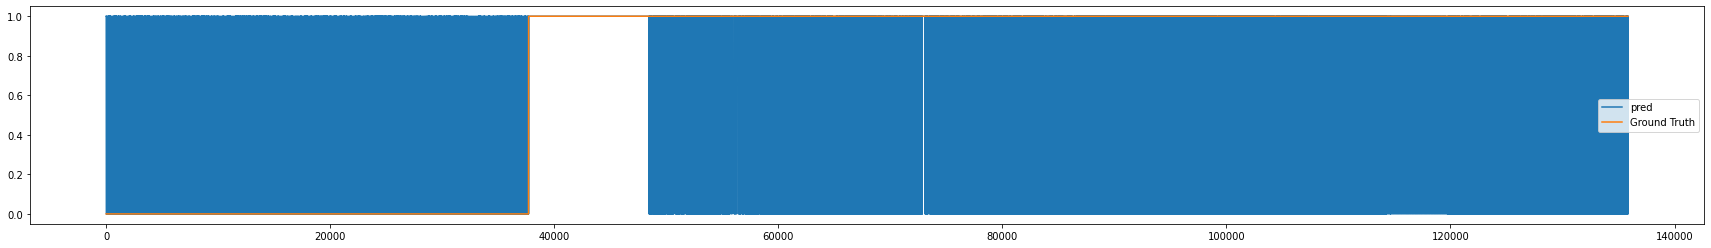

In [33]:
fig = plt.figure(figsize=(35, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

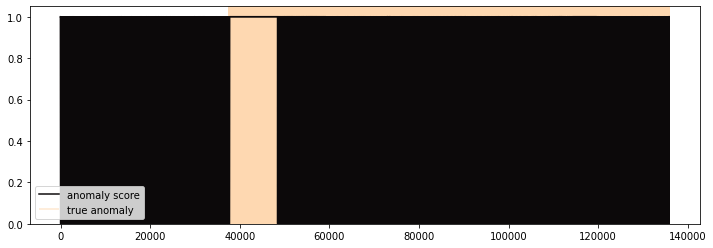

In [34]:
check_graph(IF_pred, np.array(Anode_Test_y))
plt.show()

In [35]:
IF_anomaly_score = IF_clf.score_samples(Anode_Test_X)

In [36]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-IF_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-IF_anomaly_score), 
                                                                  end=max(-IF_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.7459, F1: 0.8408, Precision: 0.7429, Recall: 0.9685


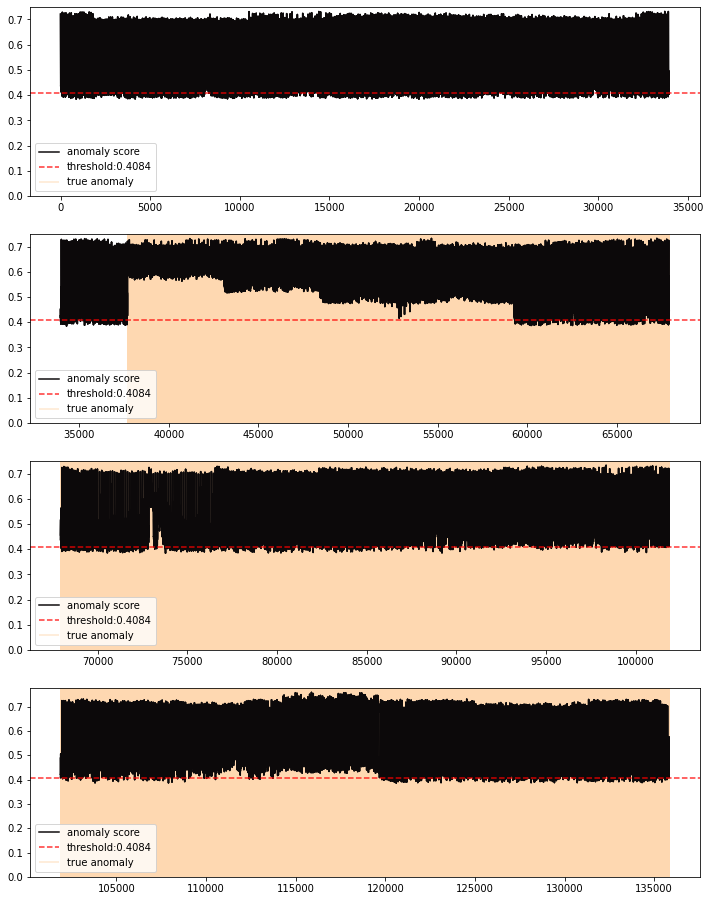

In [47]:
check_graph(-IF_anomaly_score, np.array(Anode_Test_y), threshold=threshold, piece=4)
plt.show()

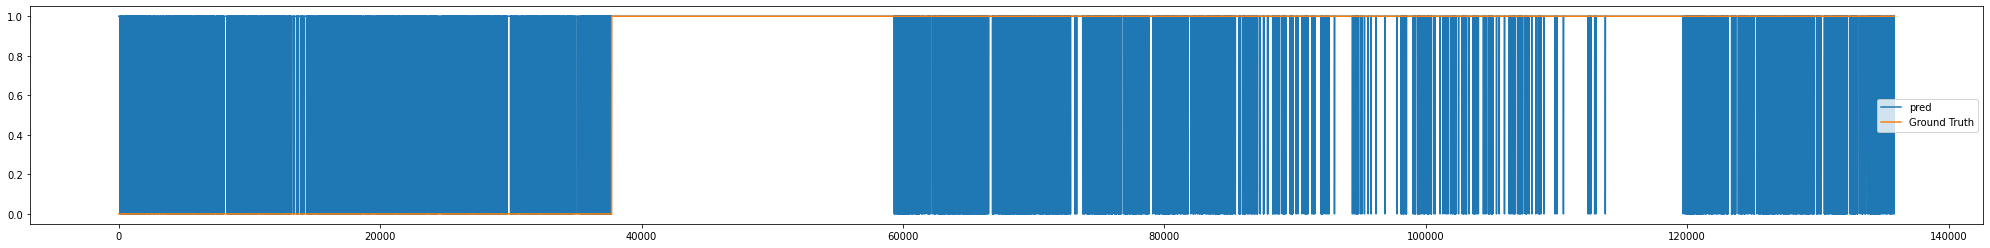

In [38]:
IF_pred = -IF_anomaly_score >= threshold
fig = plt.figure(figsize=(35, 4))
plt.plot(IF_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [77]:
Anode_Test = Anode_Test.drop('prediction', axis=1)

In [79]:
def anomaly_count_dict(testset, pred):
    anomaly_count_dict = {}
    testset['prediction'] = pred
    for bead in testset['identifier'].unique():
        anomaly_count_dict[bead] = dict(Counter(testset[testset['identifier'] == bead]['prediction']))
        
    
    return anomaly_count_dict

In [80]:
isf_anomaly_count_dict = anomaly_count_dict(Anode_Test, IF_pred)
isf_anomaly_count_dict

{'Normal_35_0': {True: 96, False: 5},
 'Normal_35_1': {True: 78, False: 22},
 'Normal_35_2': {True: 90, False: 10},
 'Normal_35_3': {True: 95, False: 5},
 'Normal_35_4': {True: 80, False: 20},
 'Normal_35_5': {True: 79, False: 21},
 'Normal_35_6': {True: 87, False: 13},
 'Normal_35_7': {True: 82, False: 18},
 'Normal_35_8': {True: 90, False: 10},
 'Normal_35_9': {True: 79, False: 21},
 'Normal_35_10': {True: 77, False: 23},
 'Normal_35_11': {True: 81, False: 19},
 'Normal_35_12': {True: 85, False: 15},
 'Normal_35_13': {True: 81, False: 19},
 'Normal_35_14': {True: 78, False: 22},
 'Normal_35_15': {True: 69, False: 31},
 'Normal_35_16': {True: 75, False: 25},
 'Normal_35_17': {True: 71, False: 29},
 'Normal_35_18': {True: 67, False: 33},
 'Normal_35_19': {True: 86, False: 13},
 'Normal_35_20': {True: 93, False: 6},
 'Normal_35_21': {True: 93, False: 6},
 'Normal_35_22': {True: 85, False: 14},
 'Normal_35_23': {True: 86, False: 13},
 'Normal_35_24': {True: 95, False: 4},
 'Normal_35_25'

In [81]:
len(isf_anomaly_count_dict)

1350

In [156]:
def anomaly_counter_each_dataset(anomaly_count_dict, ratio):
    """
    dataset별로 anomaly인 bead의 갯수가 몇개인지 출력하는 함수
    bead의 timestamp 기준 True가 전체의 ratio 이상인 경우 정상 (True), 아닌 경우 (False)로 count
    """
    anomaly_counter_each_dataset_dict = {}
    true_count = 0
    false_count = 0
    for i, bead in enumerate(anomaly_count_dict.keys()):
        try:
            if anomaly_count_dict[bead][True] > anomaly_count_dict[bead][False] * ratio /(1-ratio):
                true_count = true_count + 1
            else:
                false_count = false_count + 1
        
        except:
            if 'True' in str(anomaly_count_dict[bead]):
                true_count = true_count + 1
            
            else:
                false_count = false_count + 1
        
        if i%54 == 53:
            name_list = bead.split('_') # ['Normal', dataset, bead_num]
            name = name_list[0] + name_list[1]
            anomaly_counter_each_dataset_dict[name] = {True: true_count, False: false_count}
            
            true_count = 0
            false_count = 0
    
    return anomaly_counter_each_dataset_dict
        

In [157]:
isf_anomaly_count_dict

{'Normal_35_0': {True: 96, False: 5},
 'Normal_35_1': {True: 78, False: 22},
 'Normal_35_2': {True: 90, False: 10},
 'Normal_35_3': {True: 95, False: 5},
 'Normal_35_4': {True: 80, False: 20},
 'Normal_35_5': {True: 79, False: 21},
 'Normal_35_6': {True: 87, False: 13},
 'Normal_35_7': {True: 82, False: 18},
 'Normal_35_8': {True: 90, False: 10},
 'Normal_35_9': {True: 79, False: 21},
 'Normal_35_10': {True: 77, False: 23},
 'Normal_35_11': {True: 81, False: 19},
 'Normal_35_12': {True: 85, False: 15},
 'Normal_35_13': {True: 81, False: 19},
 'Normal_35_14': {True: 78, False: 22},
 'Normal_35_15': {True: 69, False: 31},
 'Normal_35_16': {True: 75, False: 25},
 'Normal_35_17': {True: 71, False: 29},
 'Normal_35_18': {True: 67, False: 33},
 'Normal_35_19': {True: 86, False: 13},
 'Normal_35_20': {True: 93, False: 6},
 'Normal_35_21': {True: 93, False: 6},
 'Normal_35_22': {True: 85, False: 14},
 'Normal_35_23': {True: 86, False: 13},
 'Normal_35_24': {True: 95, False: 4},
 'Normal_35_25'

In [158]:
anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(isf_anomaly_count_dict , 0.9)
anomaly_counter_each_dataset_dict

{'Normal35': {True: 16, False: 38},
 'Normal4': {True: 17, False: 37},
 'Normal5': {True: 18, False: 36},
 'Normal6': {True: 22, False: 32},
 'Normal7': {True: 24, False: 30},
 'Normal8': {True: 24, False: 30},
 'Normal9': {True: 15, False: 39},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 32, False: 22},
 'Abnormal07': {True: 33, False: 21},
 'Abnormal08': {True: 32, False: 22},
 'Abnormal09': {True: 42, False: 12},
 'Abnormal10': {True: 50, False: 4},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 48, False: 6},
 'Abnormal25': {True: 46, False: 8},
 'Abnormal26': {True: 45, False: 9}}

In [159]:
def metrics(anomaly_counter_each_dataset_dict):
    tn, fp, fn, tp = 0,0,0,0
    for name in anomaly_counter_each_dataset_dict.keys():
        if 'Ab' in name:
            tp = tp + anomaly_counter_each_dataset_dict[name][True]
            fn = fn + anomaly_counter_each_dataset_dict[name][False]
        
        else:
            fp = fp + anomaly_counter_each_dataset_dict[name][True]
            tn = tn + anomaly_counter_each_dataset_dict[name][False]

    recall = tp/(tp + fp)
    precision = tp/(tp + fn)
    f1 = 2*recall*precision/(recall + precision)
    
    return recall, precision, f1

In [163]:
recall, precision, f1 = metrics(anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8785, precision: 0.8930, recall: 0.8645


### One-class SVM

In [121]:
OCS_clf = OneClassSVM().fit(Anode_Train_X)
OCS_pred = OCS_clf.predict(Anode_Test_X)
OCS_pred = np.where(OCS_pred==1, 0, 1)

In [122]:
tn, fp, fn, tp = confusion_matrix(Anode_Test_y, OCS_pred).ravel()
(tn, fp, fn, tp)

(18933, 18766, 33443, 64705)

In [128]:
OCS_anomaly_score = OCS_clf.score_samples(Anode_Test_X)

In [131]:
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-OCS_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-OCS_anomaly_score), 
                                                                  end=max(-OCS_anomaly_score), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

AUROC: 0.6102, F1: 0.8375, Precision: 0.7220, Recall: 0.9969


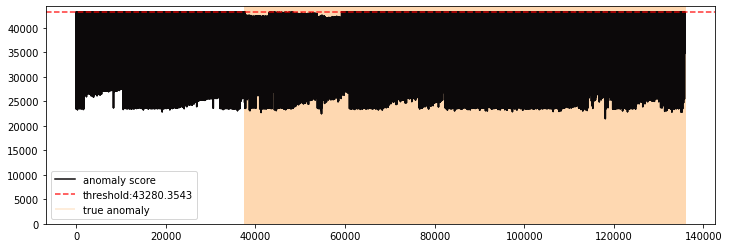

In [132]:
check_graph(OCS_anomaly_score, np.array(Anode_Test_y), threshold=-threshold)
plt.show()

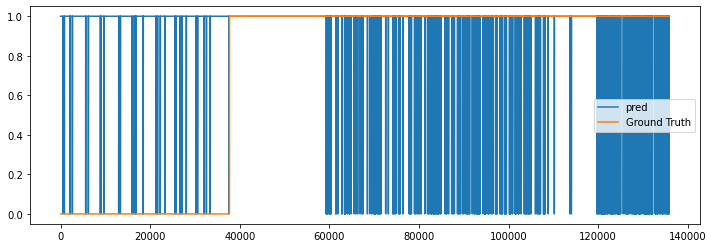

In [133]:
OCS_pred = OCS_anomaly_score <= -threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(OCS_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [134]:
OCM_anomaly_count_dict = anomaly_count_dict(Anode_Test, OCS_pred)
OCM_anomaly_count_dict

{'Normal_35_0': {True: 101},
 'Normal_35_1': {True: 100},
 'Normal_35_2': {True: 100},
 'Normal_35_3': {True: 100},
 'Normal_35_4': {True: 100},
 'Normal_35_5': {True: 99, False: 1},
 'Normal_35_6': {True: 100},
 'Normal_35_7': {True: 100},
 'Normal_35_8': {True: 99, False: 1},
 'Normal_35_9': {True: 100},
 'Normal_35_10': {True: 100},
 'Normal_35_11': {True: 100},
 'Normal_35_12': {True: 100},
 'Normal_35_13': {True: 100},
 'Normal_35_14': {True: 100},
 'Normal_35_15': {True: 100},
 'Normal_35_16': {True: 100},
 'Normal_35_17': {True: 100},
 'Normal_35_18': {True: 100},
 'Normal_35_19': {True: 99},
 'Normal_35_20': {True: 98, False: 1},
 'Normal_35_21': {True: 98, False: 1},
 'Normal_35_22': {True: 99},
 'Normal_35_23': {True: 99},
 'Normal_35_24': {True: 99},
 'Normal_35_25': {True: 99},
 'Normal_35_26': {True: 98, False: 1},
 'Normal_35_27': {True: 99},
 'Normal_35_28': {True: 100},
 'Normal_35_29': {True: 99},
 'Normal_35_30': {True: 99},
 'Normal_35_31': {True: 99},
 'Normal_35_32

In [164]:
OCM_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(OCM_anomaly_count_dict, 0.9)
OCM_anomaly_counter_each_dataset_dict

{'Normal35': {True: 54, False: 0},
 'Normal4': {True: 54, False: 0},
 'Normal5': {True: 54, False: 0},
 'Normal6': {True: 54, False: 0},
 'Normal7': {True: 54, False: 0},
 'Normal8': {True: 54, False: 0},
 'Normal9': {True: 54, False: 0},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 54, False: 0},
 'Abnormal08': {True: 54, False: 0},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal10': {True: 54, False: 0},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 54, False: 0},
 'Abnormal25': {True: 54, False: 0},
 'Abnormal26': {True: 54, False: 0}}

In [165]:
recall, precision, f1 = metrics(OCM_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8372, precision: 1.0000, recall: 0.7200


### MoG

In [136]:
# Define the number of mixture components (Gaussian distributions)
n_components = 2

# Create a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components, random_state=72).fit(Anode_Train_X)

In [137]:
# Predict cluster labels for each data point
cluster_labels = gmm.predict(Anode_Test_X)

# Predict probabilities of each data point belonging to each cluster
cluster_probs = gmm.predict_proba(Anode_Test_X)

AUROC: 0.7760, F1: 0.8430, Precision: 0.7672, Recall: 0.9356


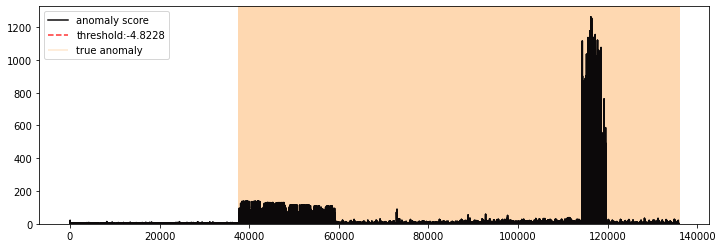

In [138]:
MoG_anomaly_score = gmm.score_samples(Anode_Test_X)

(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-MoG_anomaly_score, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-MoG_anomaly_score), 
                                                                  end=max(-MoG_anomaly_score), 
                                                                  step_num=10000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-MoG_anomaly_score, np.array(Anode_Test_y), threshold=threshold)
plt.show()

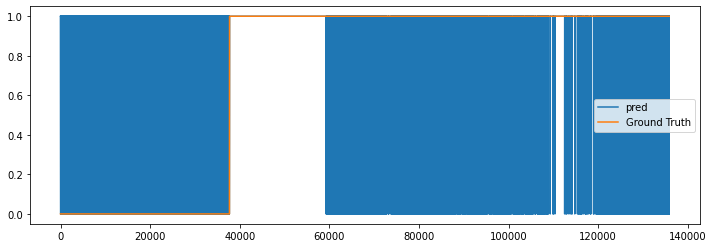

In [139]:
MoG_pred = -MoG_anomaly_score >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(MoG_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [166]:
MOG_anomaly_count_dict = anomaly_count_dict(Anode_Test, MoG_pred)
MOG_anomaly_count_dict

{'Normal_35_0': {True: 89, False: 12},
 'Normal_35_1': {True: 70, False: 30},
 'Normal_35_2': {True: 75, False: 25},
 'Normal_35_3': {True: 72, False: 28},
 'Normal_35_4': {True: 64, False: 36},
 'Normal_35_5': {True: 74, False: 26},
 'Normal_35_6': {True: 64, False: 36},
 'Normal_35_7': {True: 75, False: 25},
 'Normal_35_8': {True: 81, False: 19},
 'Normal_35_9': {True: 78, False: 22},
 'Normal_35_10': {True: 59, False: 41},
 'Normal_35_11': {True: 71, False: 29},
 'Normal_35_12': {True: 75, False: 25},
 'Normal_35_13': {True: 58, False: 42},
 'Normal_35_14': {True: 65, False: 35},
 'Normal_35_15': {True: 54, False: 46},
 'Normal_35_16': {True: 69, False: 31},
 'Normal_35_17': {True: 74, False: 26},
 'Normal_35_18': {True: 61, False: 39},
 'Normal_35_19': {True: 70, False: 29},
 'Normal_35_20': {True: 63, False: 36},
 'Normal_35_21': {True: 78, False: 21},
 'Normal_35_22': {True: 54, False: 45},
 'Normal_35_23': {True: 58, False: 41},
 'Normal_35_24': {True: 62, False: 37},
 'Normal_3

In [167]:
MoG_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(MOG_anomaly_count_dict, 0.9)
MoG_anomaly_counter_each_dataset_dict

{'Normal35': {True: 2, False: 52},
 'Normal4': {True: 2, False: 52},
 'Normal5': {True: 5, False: 49},
 'Normal6': {True: 1, False: 53},
 'Normal7': {True: 1, False: 53},
 'Normal8': {True: 5, False: 49},
 'Normal9': {True: 4, False: 50},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 10, False: 44},
 'Abnormal07': {True: 16, False: 38},
 'Abnormal08': {True: 13, False: 41},
 'Abnormal09': {True: 15, False: 39},
 'Abnormal10': {True: 21, False: 33},
 'Abnormal11': {True: 40, False: 14},
 'Abnormal12': {True: 46, False: 8},
 'Abnormal13': {True: 49, False: 5},
 'Abnormal14': {True: 52, False: 2},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 30, False: 24},
 'Abnormal25': {True: 25, False: 29},
 'Abnormal26': {True: 30, False: 24}}

In [168]:
recall, precision, f1 = metrics(MoG_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8070, precision: 0.6903, recall: 0.9711


In [ ]:
bead_counter = []
for i in range(len(MoG_pred)//54):
    bead_counter.append(dict(Counter(MoG_pred[i*54: (i+1)*54])))
print(bead_counter)

[{False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {True: 54}, {False: 54}, {False: 54}, {False: 54}]


### Parzen windows

In [143]:
bandwidth = 1.0
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(Anode_Train_X)

AUROC: 0.5579, F1: 0.8325, Precision: 0.7266, Recall: 0.9745


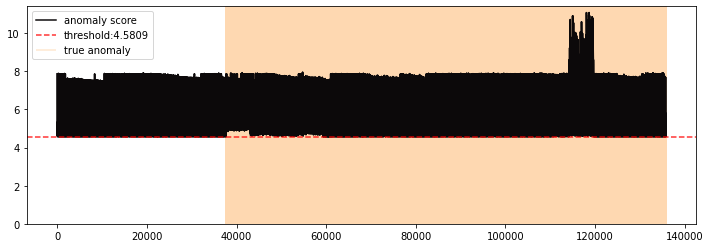

In [144]:
# Estimate the density at each value in the range
# density = np.exp(kde.score_samples(Anode_Test_X))
density = kde.score_samples(Anode_Test_X)
(f1, precision, recall, _, _, _, _, AUROC, _, _), threshold = bf_search(-density, 
                                                                  np.array(Anode_Test_y), 
                                                                  start=min(-density), 
                                                                  end=max(-density), 
                                                                  step_num=1000, 
                                                                  K=100, 
                                                                  verbose=False)
print(f'AUROC: {AUROC:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
check_graph(-density, np.array(Anode_Test_y), threshold=threshold)
plt.show()

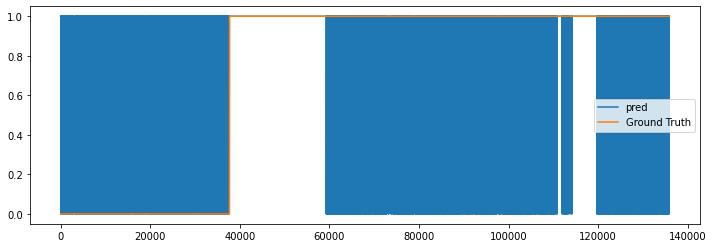

In [146]:
PW_pred = -density >= threshold
fig = plt.figure(figsize=(12, 4))
plt.plot(PW_pred, label='pred')
plt.plot(np.array(Anode_Test_y), label='Ground Truth')
plt.legend()
plt.show()

In [170]:
PW_anomaly_count_dict = anomaly_count_dict(Anode_Test, PW_pred)
PW_anomaly_count_dict

{'Normal_35_0': {True: 100, False: 1},
 'Normal_35_1': {True: 94, False: 6},
 'Normal_35_2': {True: 95, False: 5},
 'Normal_35_3': {True: 96, False: 4},
 'Normal_35_4': {True: 94, False: 6},
 'Normal_35_5': {True: 96, False: 4},
 'Normal_35_6': {True: 95, False: 5},
 'Normal_35_7': {True: 95, False: 5},
 'Normal_35_8': {True: 94, False: 6},
 'Normal_35_9': {True: 95, False: 5},
 'Normal_35_10': {True: 94, False: 6},
 'Normal_35_11': {True: 94, False: 6},
 'Normal_35_12': {True: 95, False: 5},
 'Normal_35_13': {True: 96, False: 4},
 'Normal_35_14': {True: 96, False: 4},
 'Normal_35_15': {True: 94, False: 6},
 'Normal_35_16': {True: 95, False: 5},
 'Normal_35_17': {True: 94, False: 6},
 'Normal_35_18': {True: 95, False: 5},
 'Normal_35_19': {True: 93, False: 6},
 'Normal_35_20': {True: 93, False: 6},
 'Normal_35_21': {True: 95, False: 4},
 'Normal_35_22': {True: 92, False: 7},
 'Normal_35_23': {True: 94, False: 5},
 'Normal_35_24': {True: 99},
 'Normal_35_25': {True: 94, False: 5},
 'Nor

In [171]:
PW_anomaly_counter_each_dataset_dict = anomaly_counter_each_dataset(PW_anomaly_count_dict, 0.9)
PW_anomaly_counter_each_dataset_dict

{'Normal35': {True: 54, False: 0},
 'Normal4': {True: 54, False: 0},
 'Normal5': {True: 54, False: 0},
 'Normal6': {True: 54, False: 0},
 'Normal7': {True: 54, False: 0},
 'Normal8': {True: 54, False: 0},
 'Normal9': {True: 54, False: 0},
 'Abnormal01': {True: 54, False: 0},
 'Abnormal02': {True: 54, False: 0},
 'Abnormal04': {True: 54, False: 0},
 'Abnormal05': {True: 54, False: 0},
 'Abnormal06': {True: 54, False: 0},
 'Abnormal07': {True: 54, False: 0},
 'Abnormal08': {True: 54, False: 0},
 'Abnormal09': {True: 54, False: 0},
 'Abnormal10': {True: 54, False: 0},
 'Abnormal11': {True: 54, False: 0},
 'Abnormal12': {True: 54, False: 0},
 'Abnormal13': {True: 54, False: 0},
 'Abnormal14': {True: 54, False: 0},
 'Abnormal15': {True: 54, False: 0},
 'Abnormal18': {True: 54, False: 0},
 'Abnormal24': {True: 54, False: 0},
 'Abnormal25': {True: 53, False: 1},
 'Abnormal26': {True: 54, False: 0}}

In [172]:
recall, precision, f1 = metrics(PW_anomaly_counter_each_dataset_dict)
print(f"f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

f1: 0.8367, precision: 0.9990, recall: 0.7198


In [42]:
bead_counter = []
for i in range(len(PW_pred)//54):
    bead_counter.append(dict(Counter(PW_pred[i*54: (i+1)*54])))
print(bead_counter)

[{True: 1, False: 53}, {False: 54}, {False: 54}, {False: 54}, {False: 54}, {False: 53, True: 1}, {False: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {True: 54}, {False: 52, True: 2}, {True: 28, False: 26}, {True: 53, False: 1}, {True: 54}, {True: 54}, {True: 44, False: 10}, {False: 25, True: 29}, {True: 54}, {False: 48, True: 6}, {False: 54}, {False: 54}]


In [43]:
len(bead_counter)

25

---